In [ ]:
!pip install -U qiskit

  Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)
Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.0 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.4.5
    Uninstalling qiskit-1.4.5:
      Successfully uninstalled qiskit-1.4.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-machine-learning 0.8.4 requires qiskit<2.0,>=1.0, but you have qiskit 2.2.3 which is incompatible.


In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-ibm-runtime

In [ ]:
pip install qiskit[visualization]

In [ ]:
pip install qiskit-ibm-runtime

In [ ]:
pip install qiskit[visualization]

In [ ]:
pip install qiskit_machine_learning

  Using cached qiskit-1.4.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit-1.4.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.8 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.2.3
    Uninstalling qiskit-2.2.3:
      Successfully uninstalled qiskit-2.2.3


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import zz_feature_map  # 2025-style
from qiskit.primitives.sampler import Sampler


from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
csv_path = Path("data.csv")
df = pd.read_csv(csv_path)

# drop obvious junk cols
df = df.drop(columns=[c for c in df.columns if c.startswith("Unnamed")], errors="ignore")
df = df.drop(columns=["id"], errors="ignore")

# target to 0/1
df["diagnosis"] = (df["diagnosis"] == "M").astype(int)

# these are the 10 you listed, in order
bio_cols = [
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave points_mean",
    "symmetry_mean",
    "fractal_dimension_mean",
]

X_raw = df[bio_cols].values
y = df["diagnosis"].values


In [ ]:
def make_bio_factors(X10: np.ndarray) -> np.ndarray:
    # X10 shape: (n, 10), ordered as in bio_cols above
    radius = X10[:, 0]
    texture = X10[:, 1]
    perimeter = X10[:, 2]
    area = X10[:, 3]
    smoothness = X10[:, 4]
    compactness = X10[:, 5]
    concavity = X10[:, 6]
    concave_pts = X10[:, 7]
    symmetry = X10[:, 8]
    fractal = X10[:, 9]

    # 1) size / scale
    size = np.stack([radius, perimeter, area], axis=1).mean(axis=1)

    # 2) shape / compactness
    shape = np.stack([smoothness, compactness], axis=1).mean(axis=1)

    # 3) irregularity / malignancy
    irregular = np.stack([concavity, concave_pts], axis=1).mean(axis=1)

    # 4) texture (keep as is)
    texture_f = texture

    # 5) global geometry
    global_geom = np.stack([symmetry, fractal], axis=1).mean(axis=1)

    X5 = np.vstack([size, shape, irregular, texture_f, global_geom]).T
    return X5

X_5f = make_bio_factors(X_raw)
num_qubits = X_5f.shape[1]   # = 5
print("using", num_qubits, "qubits")


using 5 qubits


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_5f, y, test_size=0.25, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

def to_angles_row(x):
    # squash standardized values to [0, pi]
    return (np.tanh(x) + 1) * (np.pi / 2)

X_train_ang = np.apply_along_axis(to_angles_row, 1, X_train_std)
X_test_ang = np.apply_along_axis(to_angles_row, 1, X_test_std)


In [ ]:
standard_fmap = zz_feature_map(
    feature_dimension=num_qubits,
    reps=2,
    entanglement="full",
)
print(standard_fmap)


   ┌───┐┌─────────────┐                                               »
0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
   ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(x[0] - π)*(x[1] - π)) ├┤ X ├──┼──»
   ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
   ├───┤├─────────────┤                                          └───┘»
3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
   ├───┤├─────────────┤                                               »
4: ┤ H ├┤ P(2.0*x[4]) ├───────────────────────────────────────────────»
   └───┘└─────────────┘                                               »
«                                                                             »
«0: ──────────────────────────────────■────■──────────────────────────────────»
«                                     │    │    

In [ ]:
import numpy as np
from qiskit.circuit import QuantumCircuit, ParameterVector

def bio_feature_map_5(reps: int = 2) -> QuantumCircuit:
    n = 5
    x = ParameterVector("x", n)
    qc = QuantumCircuit(n, name="bio_fmap_5")

    for _ in range(reps):
        # 1) single-qubit encoding
        for i in range(n):
            qc.ry(x[i], i)
            qc.rz(np.pi/2 * (1 - x[i]), i)

        # 2) biologically motivated entanglement
        qc.cz(0, 1)  # size ↔ shape
        qc.cz(2, 3)  # irregular ↔ texture

        # 3) global geometry talks to others
        qc.cz(4, 0)
        qc.cz(4, 2)

        qc.barrier()

    return qc

custom_fmap = bio_feature_map_5(reps=2)
print(custom_fmap)


     ┌──────────┐┌────────────────────┐          ░ ┌──────────┐»
q_0: ┤ Ry(x[0]) ├┤ Rz(π/2 - π/2*x[0]) ├─■──■─────░─┤ Ry(x[0]) ├»
     ├──────────┤├────────────────────┤ │  │     ░ ├──────────┤»
q_1: ┤ Ry(x[1]) ├┤ Rz(π/2 - π/2*x[1]) ├─■──┼─────░─┤ Ry(x[1]) ├»
     ├──────────┤├────────────────────┤    │     ░ ├──────────┤»
q_2: ┤ Ry(x[2]) ├┤ Rz(π/2 - π/2*x[2]) ├─■──┼──■──░─┤ Ry(x[2]) ├»
     ├──────────┤├────────────────────┤ │  │  │  ░ ├──────────┤»
q_3: ┤ Ry(x[3]) ├┤ Rz(π/2 - π/2*x[3]) ├─■──┼──┼──░─┤ Ry(x[3]) ├»
     ├──────────┤├────────────────────┤    │  │  ░ ├──────────┤»
q_4: ┤ Ry(x[4]) ├┤ Rz(π/2 - π/2*x[4]) ├────■──■──░─┤ Ry(x[4]) ├»
     └──────────┘└────────────────────┘          ░ └──────────┘»
«     ┌────────────────────┐          ░ 
«q_0: ┤ Rz(π/2 - π/2*x[0]) ├─■──■─────░─
«     ├────────────────────┤ │  │     ░ 
«q_1: ┤ Rz(π/2 - π/2*x[1]) ├─■──┼─────░─
«     ├────────────────────┤    │     ░ 
«q_2: ┤ Rz(π/2 - π/2*x[2]) ├─■──┼──■──░─
«     ├────────────────────┤ │  │  │  ░

In [ ]:
pip install qiskit.algorithms

In [ ]:
pip install -U qiskit qiskit-machine-learning qiskit-algorithms

  Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)


In [ ]:

from qiskit_algorithms.state_fidelities import ComputeUncompute

from qiskit.quantum_info import Statevector
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# ----- 1. helper: bind data -> circuit -----
def bind_feature_map(fmap, x):
    # fmap.parameters is an ordered set like [x[0], x[1], ...]
    param_dict = {p: float(x[i]) for i, p in enumerate(sorted(fmap.parameters, key=lambda z: z.name))}
    return fmap.assign_parameters(param_dict, inplace=False)

# ----- 2. helper: turn all data into statevectors -----
def states_from_data(fmap, X):
    states = []
    for x in X:
        circ = bind_feature_map(fmap, x)
        sv = Statevector.from_instruction(circ)
        states.append(sv)
    return states

# make statevectors for train/test for both maps
std_train_states = states_from_data(standard_fmap, X_train_ang)
std_test_states  = states_from_data(standard_fmap, X_test_ang)

bio_train_states = states_from_data(custom_fmap, X_train_ang)
bio_test_states  = states_from_data(custom_fmap, X_test_ang)

# ----- 3. helper: build kernel matrix K_ij = |<psi_i|phi_j>|^2 -----
def kernel_matrix(states_A, states_B):
    na, nb = len(states_A), len(states_B)
    K = np.zeros((na, nb))
    for i, sa in enumerate(states_A):
        v_a = sa.data
        for j, sb in enumerate(states_B):
            v_b = sb.data
            K[i, j] = np.abs(np.vdot(v_a, v_b)) ** 2
    return K

# standard (ZZ) kernel matrices
K_train_std = kernel_matrix(std_train_states, std_train_states)
K_test_std  = kernel_matrix(std_test_states, std_train_states)  # note: test vs train

# custom (bio) kernel matrices
K_train_bio = kernel_matrix(bio_train_states, bio_train_states)
K_test_bio  = kernel_matrix(bio_test_states, bio_train_states)

# ----- 4. train classical SVMs on precomputed kernels -----
svc_std = SVC(kernel="precomputed")
svc_std.fit(K_train_std, y_train)
y_pred_std = svc_std.predict(K_test_std)
acc_std = accuracy_score(y_test, y_pred_std)

svc_bio = SVC(kernel="precomputed")
svc_bio.fit(K_train_bio, y_train)
y_pred_bio = svc_bio.predict(K_test_bio)
acc_bio = accuracy_score(y_test, y_pred_bio)

print(f"5-qubit ZZ fmap accuracy:   {acc_std:.3f}")
print(f"5-qubit BIO fmap accuracy:  {acc_bio:.3f}")

5-qubit ZZ fmap accuracy:   0.755
5-qubit BIO fmap accuracy:  0.888


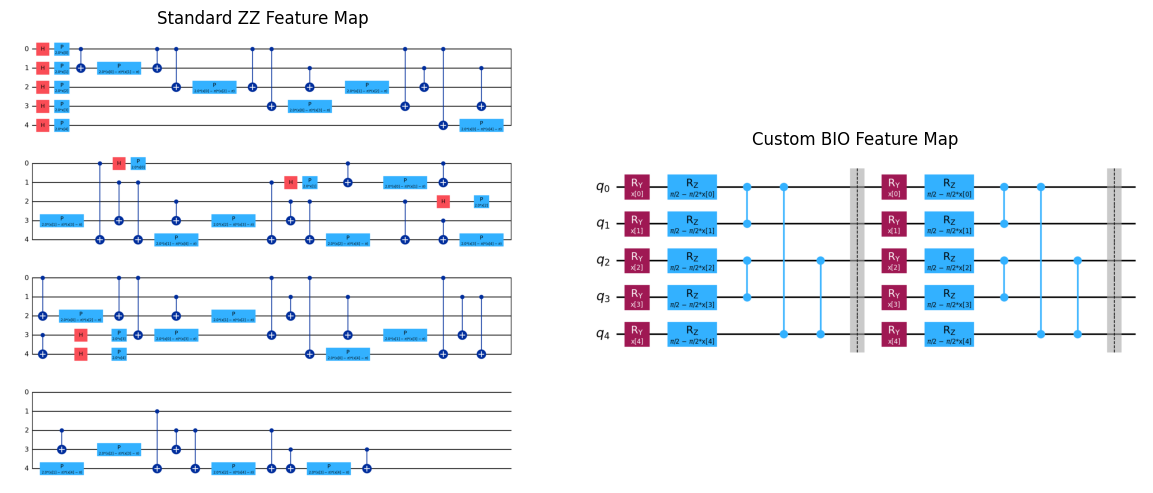

In [ ]:
from qiskit.visualization import circuit_drawer
from PIL import Image
import matplotlib.pyplot as plt

# Draw both circuits as images
circuit_drawer(standard_fmap, output='mpl', filename='standard_circuit.png')
circuit_drawer(custom_fmap, output='mpl', filename='bio_circuit.png')

# Load and display them side by side
img1 = Image.open('standard_circuit.png')
img2 = Image.open('bio_circuit.png')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title("Standard ZZ Feature Map")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title("Custom BIO Feature Map")

plt.tight_layout()
plt.show()



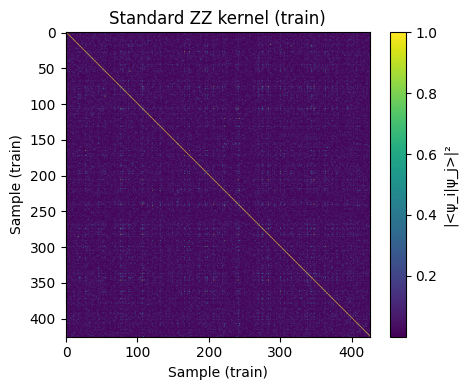

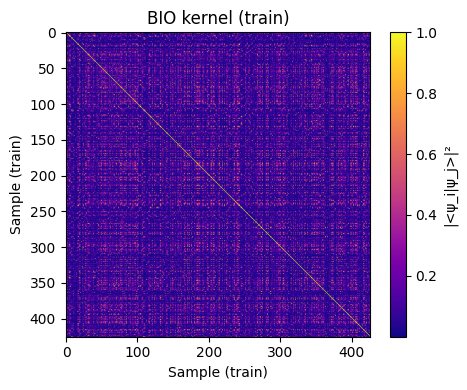

In [ ]:
import matplotlib.pyplot as plt

# 1) standard ZZ kernel
plt.figure(figsize=(5, 4))
plt.imshow(K_train_std, cmap="viridis")
plt.title("Standard ZZ kernel (train)")
plt.xlabel("Sample (train)")
plt.ylabel("Sample (train)")
plt.colorbar(label="|<ψ_i|ψ_j>|²")
plt.tight_layout()
plt.show()

# 2) BIO kernel
plt.figure(figsize=(5, 4))
plt.imshow(K_train_bio, cmap="plasma")
plt.title("BIO kernel (train)")
plt.xlabel("Sample (train)")
plt.ylabel("Sample (train)")
plt.colorbar(label="|<ψ_i|ψ_j>|²")
plt.tight_layout()
plt.show()
